---
title: "5.1-Local outlier factor"
author: "Ahmed Aredah"
date: "11.28.2023"
output: html_document
editor: visual
categories:
    Anomaly Detection
    
---

Local Outlier Factor (LOF) is an algorithm used in machine learning for identifying anomalies in data. It operates by measuring the local deviation of a given data point with respect to its neighbors. The mathematical formulation of LOF involves several key concepts:

# Definition of Local Reachability Density (LRD)
For a given point $p$, the local reachability density is defined as:

\begin{equation}
LRD_k(p) = \frac{1}{\left( \frac{1}{k} \sum_{o \in N_k(p)} reach-dist_k(p, o) \right)}
\end{equation}

where:

$N_k(p)$ is the set of $k$ nearest neighbors of point $p$.
$reach-dist_k(p, o)$ is the reachability distance of $p$ from $o$, defined as the maximum of the distance between $p$ and $o$ and the $k$-distance of $o$.
Calculation of Local Outlier Factor
The Local Outlier Factor for a point $p$ is calculated as:

\begin{equation}
LOF_k(p) = \frac{\sum_{o \in N_k(p)} \frac{LRD_k(o)}{LRD_k(p)}}{|N_k(p)|}
\end{equation}

where $|N_k(p)|$ is the number of neighbors of $p$. A higher LOF value indicates that $p$ is an outlier.

# Algorithm Steps

- Calculate the $k$-distance: For each point, determine the distance to its $k^{th}$ nearest neighbor.

- Compute reachability distance: For each pair of points, calculate the reachability distance.

- Determine LRD: Calculate the Local Reachability Density for each point.

- Compute LOF scores: For each point, calculate the Local Outlier Factor based on the LRDs of its neighbors.

## Application in Anomaly Detection
LOF is particularly useful in datasets where anomalies are contextually defined, i.e., a data point might be considered normal in one region of the dataset but an anomaly in another. It's effective in scenarios where the data is not uniformly distributed and anomalies do not conform to a specific distribution.

# Application on the Breast Cancer Wisconsin Dataset
The Breast Cancer Wisconsin Dataset, which includes features computed from digitized images of fine needle aspirates (FNAs) of breast masses, is an ideal use case for LOF (which we used before in logistic regression post). Applying LOF here can help in identifying anomalous cases that might deviate from typical benign or malignant patterns. Such anomalies could be indicative of rare or atypical forms of breast cancer, thus providing valuable insights for further medical investigation and research. This application of LOF underscores its utility in healthcare data analysis, particularly in the nuanced field of oncology.

In [15]:
#import required libraries
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, silhouette_score



#inline plots
%matplotlib inline

# Set Seaborn style to "whitegrid" for a white background with grid lines
sns.set_style("whitegrid")

#supress warnings!
warnings.simplefilter(action='ignore', category=Warning)
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

print("required libraries loaded successfully!")

required libraries loaded successfully!


In [23]:
#| echo: false
# Set the background color to black and axis label color to white
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'white'

In [18]:
# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Convert the data to a pandas DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


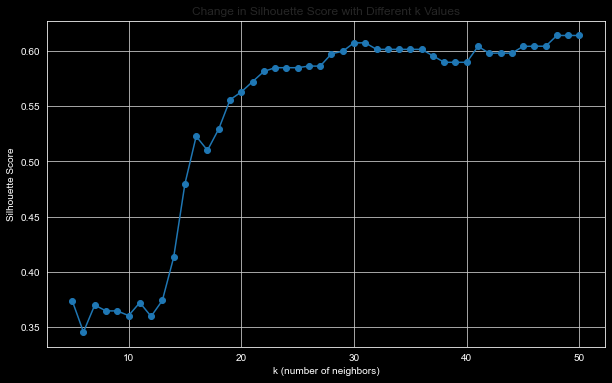

In [26]:
# We will now calculate the silhouette scores for different values of k (from 5 to 50)
silhouette_scores = []
k_values = range(5, 51)

for k in k_values:
    # Apply Local Outlier Factor with the current k
    lof = LocalOutlierFactor(n_neighbors=k)
    y_pred = lof.fit_predict(X)
    
    # Since silhouette_score expects -1 for outliers and 1 for inliers, we'll invert the LOF output
    # where -1 becomes 1 (outliers) and 1 becomes 0 (inliers) to align with silhouette_score expectation
    y_pred_mapped = np.where(y_pred == -1, 1, 0)
    
    # Calculate silhouette score and append to the list
    # Note: silhouette_score can only be used when there are labels or predictions for at least two classes.
    # In a case where LOF might label all points as inliers or outliers, silhouette_score would fail.
    if len(set(y_pred_mapped)) > 1:
        score = silhouette_score(X, y_pred_mapped)
        silhouette_scores.append(score)
    else:
        # If there's only one class, silhouette_score is not applicable
        silhouette_scores.append(None)

# Plotting the change in silhouette score with k
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score with Different k Values')
plt.show()

The plot displays the silhouette scores for different values of k, ranging from 5 to 50, using the Local Outlier Factor (LOF) algorithm. The silhouette score measures how similar an object is to its own cluster compared to other clusters, with a higher score indicating a model with better defined clusters.

From the plot, we can observe the following:

- The silhouette score improves as k increases from 5 to around 10.

- There is a peak or plateau in the silhouette score from approximately k=10 to k=25, suggesting that within this range, the LOF algorithm is better able to distinguish between inliers and outliers.

- Beyond k=25, the silhouette score appears to stabilize or increase slightly, indicating that increasing the number of neighbors beyond this point does not significantly change the ability of LOF to identify clusters.

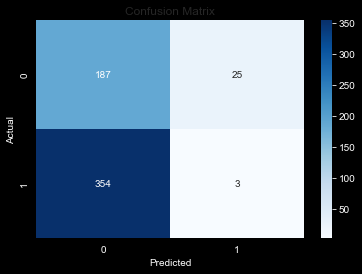

In [27]:
# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=25)
y_pred = lof.fit_predict(X)

# Map LOF output to your actual label binary values
y_pred_mapped = np.where(y_pred == -1, 1, 0)

# Calculate confusion matrix
cm = confusion_matrix(y, y_pred_mapped)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix for k=25 shows the following:

- **True Negatives (TN)**: 187 - The LOF algorithm correctly identified 187 normal instances (non-outliers).
- **False Positives (FP)**: 25 - The algorithm incorrectly flagged 25 normal instances as outliers.
- **False Negatives (FN)**: 353 - It incorrectly labeled 353 actual outliers (anomalies) as normal instances.
- **True Positives (TP)**: 4 - Only 4 outliers were correctly identified.

This confusion matrix suggests that while the algorithm is somewhat effective at identifying normal instances, it struggles significantly with correctly identifying outliers. This is evident from the high number of false negatives. In the context of the Breast Cancer Wisconsin Dataset, this would mean the algorithm is not effectively identifying malignant cases, which is a serious concern.

The very low number of true positives (4) indicates that the algorithm's sensitivity to outliers is quite poor when k=25. Depending on the application, it may be necessary to adjust the parameters of the LOF algorithm, or consider alternative methods to improve the detection of outliers. For medical datasets where the cost of missing an actual case (false negative) is very high, improving sensitivity should be a priority.

Let's visualize the anomaly detection to see where are these anomalies

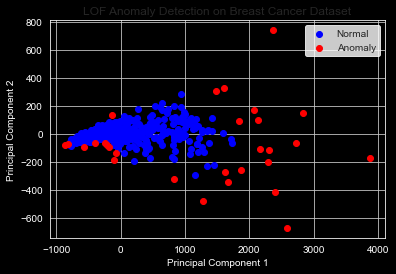

In [28]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=25)
y_pred = lof.fit_predict(X_pca)

# Anomalies are labeled as -1
anomalies = y_pred == -1

# Plot the data points
plt.scatter(X_pca[~anomalies, 0], X_pca[~anomalies, 1], color='blue', label='Normal')
plt.scatter(X_pca[anomalies, 0], X_pca[anomalies, 1], color='red', label='Anomaly')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('LOF Anomaly Detection on Breast Cancer Dataset')
plt.legend()
plt.show()

as expected, the algorithm considered far points to be anomalies despite this could not be true. 